<a href="https://colab.research.google.com/github/jonathansantoss/Aprovacao_creditos/blob/master/Aprovacao_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [49]:
dataset_treino = pd.read_csv('treino.csv')
dataset_treino.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [50]:
dataset_teste = pd.read_csv('teste.csv')
dataset_teste.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


In [51]:
dataset_treino.isna().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [52]:
dataset_teste.isna().sum()

util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                           7968
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes                    1046
dtype: int64

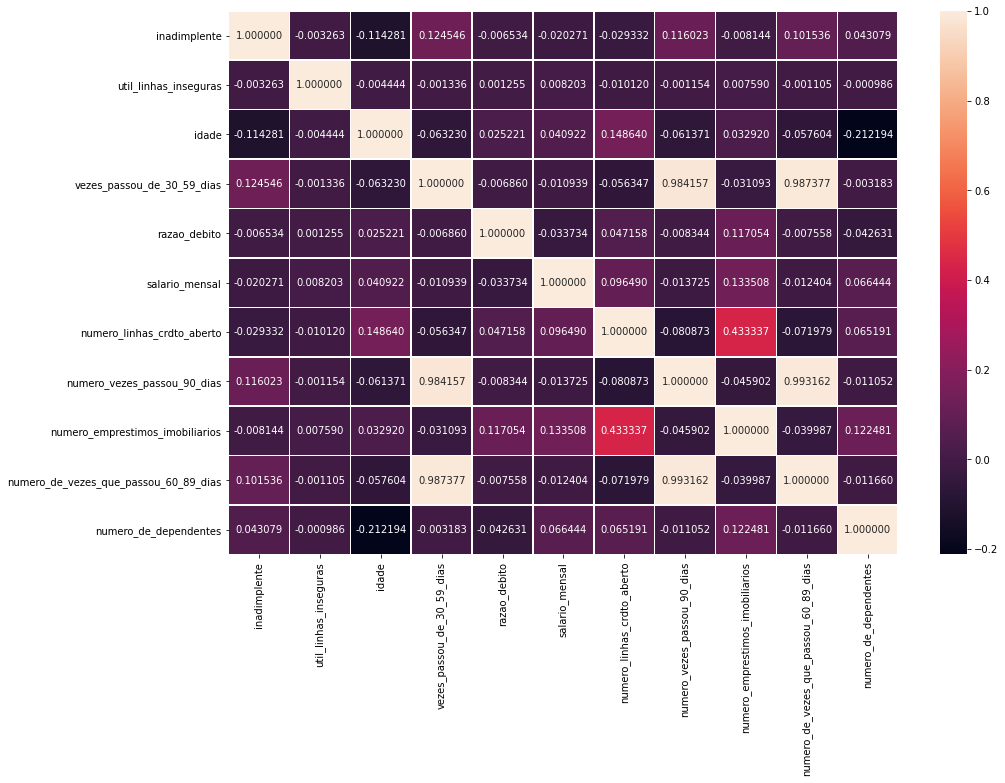

In [53]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(dataset_treino.corr(), annot=True, fmt="f", linewidths=.5, ax=ax)

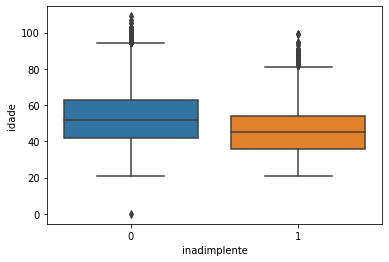

In [54]:
sns.boxplot(x="inadimplente", y="idade", data=dataset_treino)

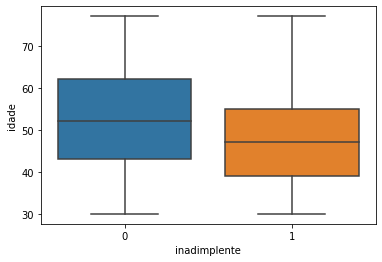

In [55]:
upper_lim = dataset_treino['idade'].quantile(.95)
lower_lim = dataset_treino['idade'].quantile(.05)

dataset_treino = dataset_treino[
                                (dataset_treino['idade'] < upper_lim) & 
                                (dataset_treino['idade'] > lower_lim)]
sns.boxplot(x="inadimplente", y="idade", data=dataset_treino)

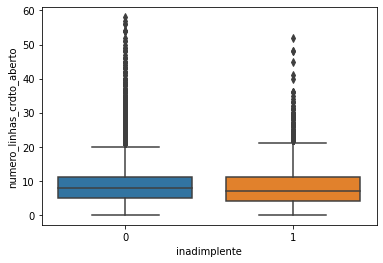

In [56]:
sns.boxplot(x="inadimplente", y="numero_linhas_crdto_aberto", data=dataset_treino)

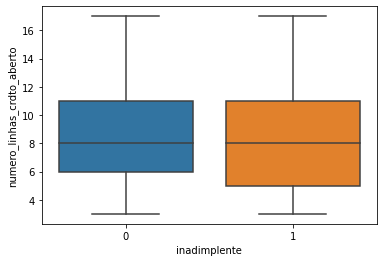

In [57]:
upper_lim = dataset_treino['numero_linhas_crdto_aberto'].quantile(.95)
lower_lim = dataset_treino['numero_linhas_crdto_aberto'].quantile(.05)

dataset_treino = dataset_treino[(
    dataset_treino['numero_linhas_crdto_aberto'] < upper_lim) & 
    (dataset_treino['numero_linhas_crdto_aberto'] > lower_lim)]

sns.boxplot(x="inadimplente",
            y="numero_linhas_crdto_aberto",
            data=dataset_treino)

In [58]:
y_treino = dataset_treino['inadimplente']
x_treino = dataset_treino.drop(columns=['numero_de_dependentes',
                                        'inadimplente'])

simpleImputer = SimpleImputer(strategy='mean')
x_treino['salario_mensal'] = simpleImputer.fit_transform(
    x_treino['salario_mensal'].values.reshape(-1, 1))
x_treino = x_treino.fillna(1)

std = StandardScaler()
x_treino_scaler = std.fit_transform(x_treino)

In [59]:
x_teste = dataset_teste.drop(columns=['numero_de_dependentes'])
x_teste['salario_mensal'] = simpleImputer.fit_transform(
    x_teste['salario_mensal'].values.reshape(-1, 1))
x_teste_scaler = std.transform(x_teste)

In [60]:
selecionar_kmelhores = SelectKBest(k= 5)
selecionar_kmelhores

SelectKBest(k=5, score_func=<function f_classif at 0x7f3c95b22ea0>)

In [61]:
X, X_val, y, y_val = train_test_split(x_treino_scaler,
                                      y_treino,
                                      random_state=42,
                                      test_size=0.2,
                                      shuffle=False)

selecionar_kmelhores = selecionar_kmelhores.fit(X, y)
X = selecionar_kmelhores.transform(X)
X_val =selecionar_kmelhores.transform(X_val)

In [62]:
km = KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=400,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances=True,
       random_state=42, tol=0.0001, verbose=0)
km.fit(X)

km_predict = km.predict(X_val)
print(f"Acurácia: {(accuracy_score(y_val, km_predict) * 100):.2f}%")

Acurácia: 93.03%


In [63]:
clf_v1 = DecisionTreeClassifier()

modelo_v1 = clf_v1.fit(X, y)
previsoes_v1 = modelo_v1.predict(X_val)

print(f"Acurácia: {(accuracy_score(y_val, previsoes_v1) * 100):.2f}%")

Acurácia: 92.17%


In [ ]:
parameters = {'criterion':['gini', 'entropy'],
         'max_features':['sqrt', 'log2'],
         'max_leaf_nodes':[2, 4, 6, 8, 10],
         'max_depth':[1, 3, 5, 7, 9, 11],
         'random_state': [42, 50, 60, 72],
         'ccp_alpha':[0.0, 0.1, 0.2, 1, 3],
         'splitter': ['best', 'random'],
         }

grid = GridSearchCV(clf_v1, param_grid=parameters)
grid.fit(X, y)
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='sqrt', max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=72, splitter='random')

In [64]:
clf_v2 = DecisionTreeClassifier(ccp_alpha=0.0,
                                class_weight=None,
                                criterion='gini',
                                max_depth=3,
                                max_features='sqrt',
                                max_leaf_nodes=6,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                min_samples_leaf=1, min_samples_split=2,
                                min_weight_fraction_leaf=0.0,
                                presort='deprecated',
                                random_state=72,
                                splitter='random')

modelo_v2 = clf_v2.fit(X, y)
previsoes_v2 = modelo_v2.predict(X_val)

print(f"Acurácia: {(accuracy_score(y_val, previsoes_v2) * 100):.2f}%")

Acurácia: 94.10%


In [65]:
lgbm_class_v1 = lgb.LGBMClassifier(random_state=42)
modelo_v3 = lgbm_class_v1.fit(X, y)
previsoes_v3 = modelo_v3.predict(X_val)

print(f"Acurácia: {(accuracy_score(y_val, previsoes_v3) * 100):.2f}%")

Acurácia: 94.19%


In [ ]:
parameters = {'boosting_type':['gbdt', 'rf', 'dart', 'goss'],
         'learning_rate':[0.001, 0.01, 0.1, 0.3, 0.5, 0.9],
         'objective':['binary'],
         'max_depth':[1, 3, 5, 7, 9, 11],
         'random_state': [42, 50, 60, 72],
         'num_leaves': [31,  35, 50, 75, 90],
         }

lgbm_class_v2 = lgb.LGBMClassifier(random_state=42)

grid = GridSearchCV(lgbm_class_v2, param_grid=parameters)
grid.fit(X, y)
grid.best_estimator_

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=72, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [66]:
lgbm_class_v3 = lgb.LGBMClassifier(boosting_type='dart',
                                   class_weight=None,
                                   colsample_bytree=1.0,
                                   importance_type='split',
                                   learning_rate=0.5, max_depth=1,
                                   min_child_samples=20,
                                   min_child_weight=0.001,
                                   min_split_gain=0.0,
                                   n_estimators=100,
                                   n_jobs=-1,
                                   num_leaves=31,
                                   objective='binary',
                                   random_state=72,
                                   reg_alpha=0.0,
                                   reg_lambda=0.0,
                                   silent=True,
                                   subsample=1.0,
                                   subsample_for_bin=200000,
                                   subsample_freq=0)

modelo_v4 = lgbm_class_v3.fit(X, y)
previsoes_v4 = modelo_v4.predict(X_val)

print(f"Acurácia: {(accuracy_score(y_val, previsoes_v4) * 100):.2f}%")

Acurácia: 94.28%


In [67]:
lgbm_class_final = lgb.LGBMClassifier(boosting_type='dart',
                                      class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.5,
                                      max_depth=1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0,
                                      n_estimators=100,
                                      n_jobs=-1,
                                      num_leaves=31,
                                      objective='binary',
                                      random_state=72,
                                      reg_alpha=0.0,
                                      reg_lambda=0.0,
                                      silent=True,
                                      subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0)

modelo_final = lgbm_class_final.fit(x_treino_scaler, y_treino)
y_pred = modelo_final.predict(x_teste_scaler)

submission = dataset_teste
submission['inadimplente'] = y_pred
submission.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0


In [68]:
submission.to_csv('submission.csv', index=False)